# Classification using Linear Models of numbers 0, 1, 4, 5 using MNIST Dataset

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import seaborn as sns
import warnings
from collections import Counter
from metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix
)
from models import (
    PocketPLA,
    LinearRegression,
    LogisticRegression
)
warnings.filterwarnings('ignore')

In [2]:
test = pd.read_csv('dataset_digits/test_redu.csv')
test

,label,intensity,symmetry
0,0,147.933333,130.470588
1,0,131.054902,122.721569
2,0,134.890196,151.725490
3,0,139.976471,133.921569
4,0,129.580392,130.274510
...,...,...,...
1110,5,96.121569,139.521569
1111,5,98.439216,130.729412
1112,5,95.141176,122.227451
1113,5,106.882353,128.007843


In [3]:
test['label'].value_counts()

4    314
1    292
5    291
0    218
Name: label, dtype: int64

In [4]:
train = pd.read_csv('dataset_digits/train_redu.csv')
train

,label,intensity,symmetry
0,0,145.435294,148.572549
1,0,118.576471,137.113725
2,0,127.600000,134.047059
3,0,138.047059,151.003922
4,0,146.215686,122.501961
...,...,...,...
2181,5,105.686275,133.890196
2182,5,113.050980,116.698039
2183,5,110.725490,133.019608
2184,5,99.305882,132.133333


In [5]:
train['label'].value_counts()

1    608
4    577
5    576
0    425
Name: label, dtype: int64

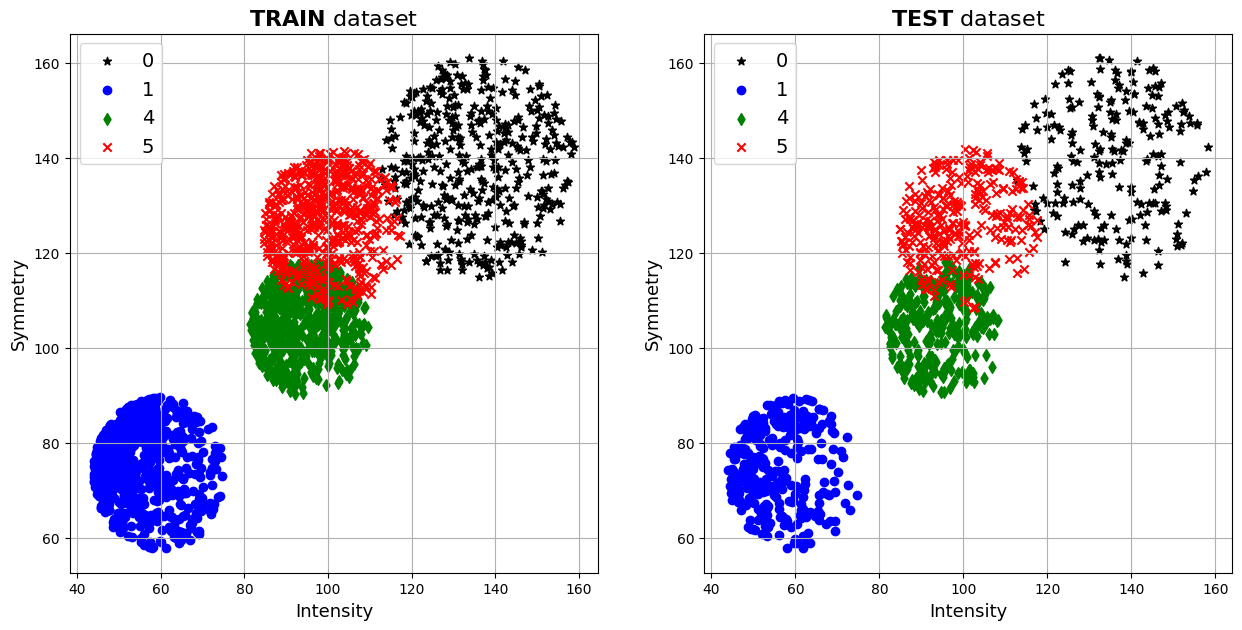

In [6]:
def plot_data(data, title, ax, idx):
    numbers = [0, 1, 4, 5]
    colors = ['black', 'blue', 'green', 'red']
    markers = ['*', 'o', 'd', 'x']
    for i in range(4):
        ax[idx].scatter(data[data['label'] == numbers[i]]['intensity'],
                   data[data['label'] == numbers[i]]['symmetry'],
                   color=colors[i],
                   label=numbers[i],
                   marker=markers[i])
    ax[idx].set_xlabel('Intensity', fontsize=13)
    ax[idx].set_ylabel('Symmetry', fontsize=13)
    ax[idx].set_title(title, fontsize = 16)
    ax[idx].legend(loc='upper left', prop={'size': 14})
    ax[idx].grid()

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
numbers = [0, 1, 4, 5]
colors = ['black', 'blue', 'green', 'red']
markers = ['*', 'o', 'd', 'x']

plot_data(train, r"$\bf{TRAIN}$ dataset", ax, 0)
plot_data(test, r"$\bf{TEST}$ dataset", ax, 1)

## Splitting train datasets based on sequence 1, 0, 4, 5

**VERY IMPORTANT POINT**

We are using here only linear classifiers, this means the we can do only binary classification, but we are gonna use **One vs Rest strategy** to classify the 4 digits. And the order of the digits is very important, because we are gonna use the sequence 1, 0, 4, 5 to split the dataset.

In [7]:
train_1 = train.copy()
train_0 = train_1[train_1['label'] != 1].reset_index(drop=True)
train_4 = train_0[train_0['label'] != 0].reset_index(drop=True)

## Extracting the X_train, y_train, X_test and y_test

In [8]:
X_train_1 = np.concatenate((np.ones((train_1.shape[0], 1)), train_1[['intensity', 'symmetry']].values), axis=1)
X_train_0 = np.concatenate((np.ones((train_0.shape[0], 1)), train_0[['intensity', 'symmetry']].values), axis=1)
X_train_4 = np.concatenate((np.ones((train_4.shape[0], 1)), train_4[['intensity', 'symmetry']].values), axis=1)
X_train = np.concatenate((np.ones((train.shape[0], 1)), train[['intensity', 'symmetry']].values), axis=1)

In [9]:
y_train_1 = np.where(train_1['label'] == 1, 1, -1)
y_train_0 = np.where(train_0['label'] == 0, 1, -1)
y_train_4 = np.where(train_4['label'] == 4, 1, -1)

print(train['label'].value_counts(), '\n')

print(Counter(y_train_1))
print(Counter(y_train_0))
print(Counter(y_train_4))

1    608
4    577
5    576
0    425
Name: label, dtype: int64 

Counter({-1: 1578, 1: 608})
Counter({-1: 1153, 1: 425})
Counter({1: 577, -1: 576})


In [10]:
# Adding the bias
X_test = np.concatenate((np.ones((test.shape[0], 1)), test[['intensity', 'symmetry']].values), axis=1)
y_test = test['label'].values

## Used X's ans y's

We are using this because we are using One vs Rest so this strategy is necessary

In [11]:
XS = [X_train_1, X_train_0, X_train_4]
YS = [y_train_1, y_train_0, y_train_4]

In [12]:
# Function to plot the classification lines
def plot_classifier(weight, classifier, log=False):
    plt.figure(figsize=(8, 8))
    plt.grid()
    x = np.linspace(40, 165, 1000)
    numbers = [0, 1, 4, 5]
    colors = ['black', 'blue', 'green', 'red']
    markers = ['*', 'o', 'd', 'x']
    l_colors = ['#fb05ff', '#ff8000', '#410563']
    lstyle = ['-', '--', '-.']
    for i in range(4):
        plt.scatter(test[test['label'] == numbers[i]]['intensity'],
                test[test['label'] == numbers[i]]['symmetry'],
                color=colors[i],
                label=numbers[i],
                marker=markers[i])
    if not log:
        for i in range(3):
            plt.plot(x, (-weight[i][0] - weight[i][1]*x) / weight[i][2], 
                     c=l_colors[i], 
                     linestyle=lstyle[i], 
                     label=f"{classifier}_{numbers[i]}")
    else:
        for i in range(3):
            a = log_reg_model.w[i][1] / -log_reg_model.w[i][2]
            b = log_reg_model.w[i][0] / -log_reg_model.w[i][2]
            plt.plot(x, a*x + b, 
                     c=l_colors[i], 
                     linestyle=lstyle[i], 
                     label=f"{classifier}_{numbers[i]}")
        
    plt.xlabel('Intensity', fontsize=13)
    plt.ylabel('Symmetry', fontsize=13)
    
    plt.legend(loc='upper left', prop={'size': 14})
    plt.xlim([40, 165])
    plt.ylim([55, 170]);
    

# Function to plot the correlation matrix using heatmap
def plot_conf_matrix(conf_matrix):
    sns.heatmap(conf_matrix,
                annot=True, 
                fmt='.0f', 
                annot_kws={'fontsize': 10, 'fontweight': 'bold'},
                cmap='PuRd',
                xticklabels=[0, 1, 4, 5],
                yticklabels=[0, 1, 4, 5])
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Real', fontsize=14)
    plt.yticks(rotation=0);

## Using PocketPLA

In [13]:
class PPLA_Classifier:
    def __init__(self, X, y):
        self.w = []
        self.X = X
        self.y = y

    def __multiple_fit(self, n_iter, idx):
        pla = PocketPLA(n_iter=int(n_iter))
        pla.fit(self.X[idx], self.y[idx])
        self.w.append(pla.get_w())
        
    def fit(self):
        self.__multiple_fit(7e4, 0)    # 70,000
        self.__multiple_fit(1.4e7, 1)  # 14,000,000
        self.__multiple_fit(1.65e7, 2)  # 16,500,000
    
    def predict(self, X):
        y_pred = []
        for i, x in enumerate(X):
            for j, num in enumerate([1, 0, 4]):
                if np.sign(x.dot(self.w[j])) == 1:
                    y_pred.append(num)
                    break
            if len(y_pred) < i+1:
                y_pred.append(5)
        return np.array(y_pred)  
    
    def set_w(self, w):
        self.w = w

In [14]:
# This was the best model I could find, don't run the next cell
ppla_model = PPLA_Classifier(XS, YS)
ppla_model.set_w(
    [
     np.array([12975,-187.65098039,21.01960784]), 
     np.array([-488056,3442.16862749,694.75294121]), 
     np.array([2.84370000e+05,-1.42490196e+02,-2.33206275e+03])
    ]
)

In [187]:
ppla_model = PPLA_Classifier(XS, YS)
ppla_model.fit()

100%|███████████████████████████████████████████████████████████████████| 16500000/16500000 [07:00<00:00, 39216.65it/s]


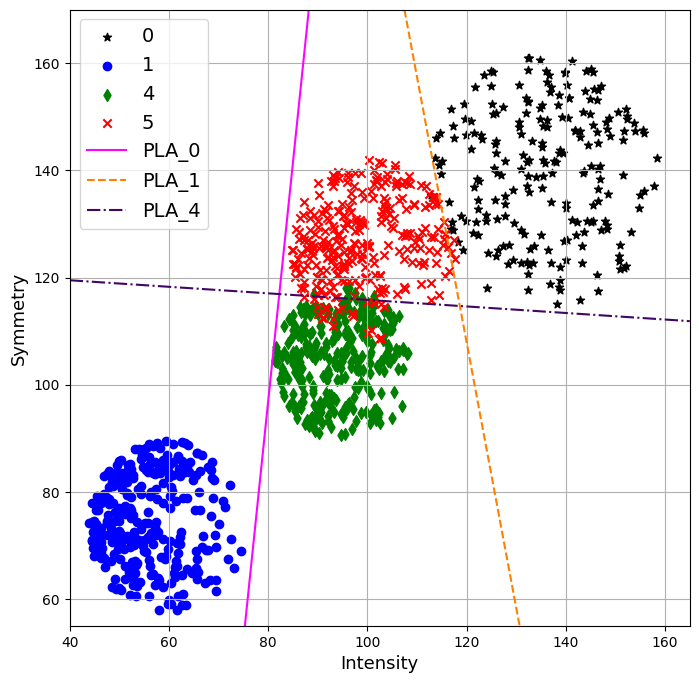

In [15]:
plot_classifier(ppla_model.w, 'PLA')

In [16]:
ppla_pred = ppla_model.predict(X_test)

    precision    recall  f1-score   support

 0       0.99      1.00      0.99       218
 1       1.00      1.00      1.00       292
 4       0.93      0.97      0.95       314
 5       0.97      0.91      0.94       291

accuracy 0.97                          1115

Ein: 0.0485
Eout: 0.0314



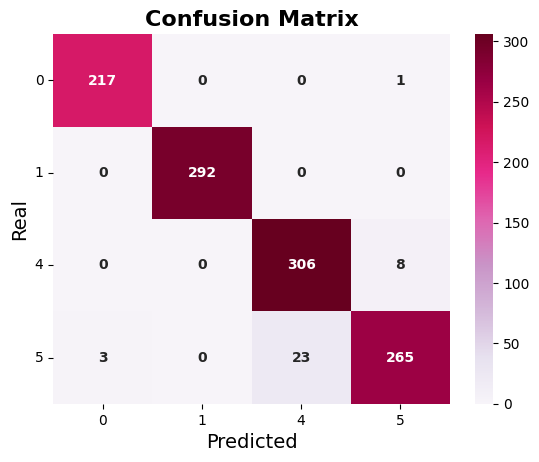

In [17]:
print(classification_report(y_test, ppla_pred))

acc_pla_train = accuracy_score(train.label, ppla_model.predict(X_train))
acc_pla_test = accuracy_score(y_test, ppla_pred)

print(f'\nEin: {1 - acc_pla_train:.4f}')
print(f'Eout: {1 - acc_pla_test:.4f}\n')

plot_conf_matrix(confusion_matrix(y_test, ppla_pred, [0, 1, 4, 5]))

In [18]:
print('Weights: ')
for idx, v in enumerate([1, 0, 4]):
    print(f'PLA{v}: {ppla_model.w[idx]}')

Weights: 
PLA1: [12975.          -187.65098039    21.01960784]
PLA0: [-488056.            3442.16862749     694.75294121]
PLA4: [ 2.84370000e+05 -1.42490196e+02 -2.33206275e+03]


## Using Linear Regression

In [19]:
class LinRegression_Classifier:
    def __init__(self, X, y):
        self.w = []
        self.X = X
        self.y = y

    def __multiple_fit(self, idx):
        lin_reg = LinearRegression()
        lin_reg.fit(self.X[idx], self.y[idx])
        self.w.append(lin_reg.get_w())
        
    def fit(self):
        self.__multiple_fit(0)
        self.__multiple_fit(1)
        self.__multiple_fit(2)
    
    def predict(self, X):
        y_pred = []
        for i, x in enumerate(X):
            for j, num in enumerate([1, 0, 4]):
                if np.sign(x.dot(self.w[j])) == 1:
                    y_pred.append(num)
                    break
            if len(y_pred) < i+1:
                y_pred.append(5)
        return np.array(y_pred)

In [20]:
lin_reg_model = LinRegression_Classifier(XS, YS)
lin_reg_model.fit()

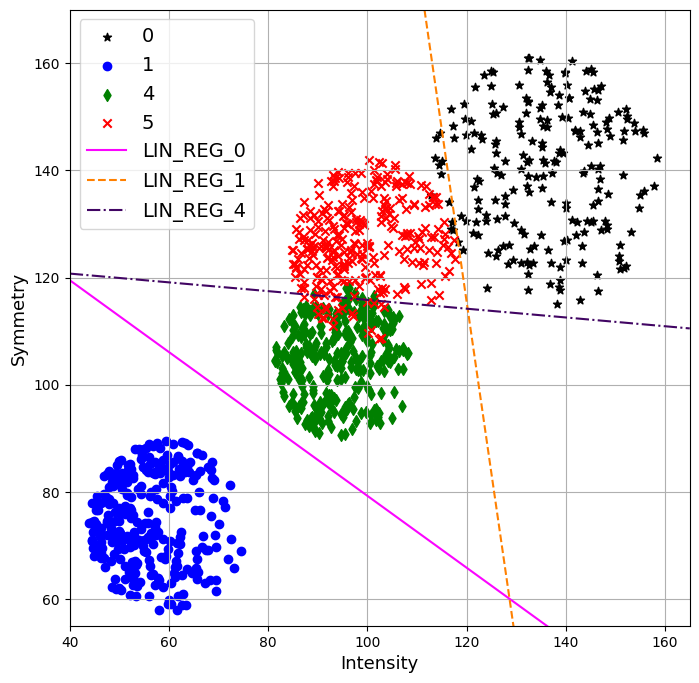

In [21]:
plot_classifier(lin_reg_model.w, 'LIN_REG')

In [22]:
lin_reg_pred = lin_reg_model.predict(X_test)

    precision    recall  f1-score   support

 0       1.00      0.95      0.97       218
 1       1.00      1.00      1.00       292
 4       0.93      0.97      0.95       314
 5       0.93      0.92      0.93       291

accuracy 0.96                          1115

Ein: 0.0526
Eout: 0.0386



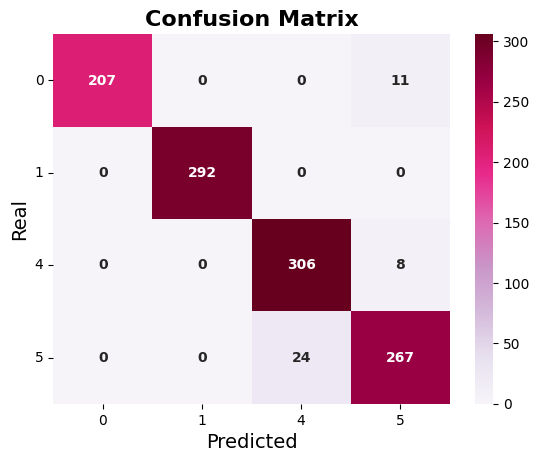

In [23]:
print(classification_report(y_test, lin_reg_pred))

acc_lin_train = accuracy_score(train.label, lin_reg_model.predict(X_train))
acc_lin_test = accuracy_score(y_test, lin_reg_pred)
                              
print(f'\nEin: {1 - acc_lin_train:.4f}')
print(f'Eout: {1 - acc_lin_test:.4f}\n')

plot_conf_matrix(confusion_matrix(y_test, lin_reg_pred, [0, 1, 4, 5]))

In [24]:
print('Weights: ')
for idx, v in enumerate([1, 0, 4]):
    print(f'LIN_REG{v}: {lin_reg_model.w[idx]}')

Weights: 
LIN_REG1: [ 2.6042966  -0.01193896 -0.01779691]
LIN_REG0: [-5.24863764  0.03802901  0.00592876]
LIN_REG4: [ 7.74261671e+00 -5.11403372e-03 -6.24322897e-02]


## Using Logistic Regression

In [25]:
class LogRegression_Classifier:
    def __init__(self, X, y):
        self.w = []
        self.X = X
        self.y = y
        
    def __multiple_fit(self, idx, tmax, batch_size):
        log_reg = LogisticRegression(tmax=tmax, batch_size=batch_size)
        log_reg.fit(self.X[idx], self.y[idx])
        self.w.append(log_reg.get_w())
        
    def fit(self):
        self.__multiple_fit(0, tmax=2e5, batch_size=512)    # 200,000
        self.__multiple_fit(1, tmax=9e5, batch_size=512)    # 900,000
        self.__multiple_fit(2, tmax=5.55e6, batch_size=512)  # 5,550,000
        
    def predict(self, X):
        y_pred = []
        for i, x in enumerate(X):
            for j, num in enumerate([1, 0, 4]):
                if np.sign(x.dot(self.w[j])) == 1:
                    y_pred.append(num)
                    break
            if len(y_pred) < i+1:
                y_pred.append(5)
        return np.array(y_pred)
    
    def set_w(self, w):
        self.w = w

In [26]:
# This was the best model I could find, don't run the next cell
log_reg_model = LogRegression_Classifier(XS, YS)
log_reg_model.set_w(
    [
     np.array([261.61244934,-3.86470732,0.44517772]), 
     np.array([-1393.93737438,10.01289702,1.81949138]), 
     np.array([3.49734173e+03,-1.75094868e+00,-2.81827811e+01])
    ]
)

In [217]:
log_reg_model = LogRegression_Classifier(XS, YS)
log_reg_model.fit()

100%|██████████████████████████████████████████████████████████████████████| 5550000/5550000 [25:02<00:00, 3693.78it/s]


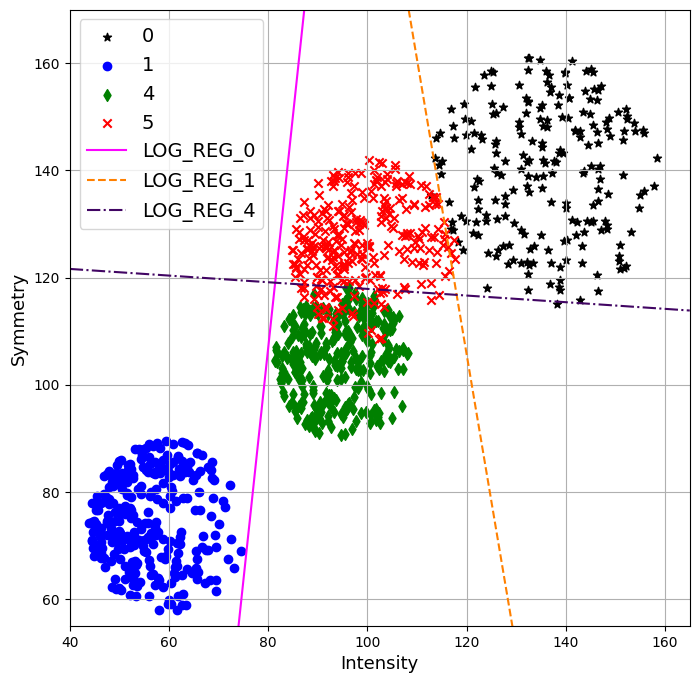

In [27]:
plot_classifier(log_reg_model.w, 'LOG_REG', True)

In [28]:
log_reg_pred = log_reg_model.predict(X_test)

    precision    recall  f1-score   support

 0       0.99      1.00      0.99       218
 1       1.00      1.00      1.00       292
 4       0.89      1.00      0.94       314
 5       1.00      0.86      0.92       291

accuracy 0.96                          1115

Ein: 0.0499
Eout: 0.0386



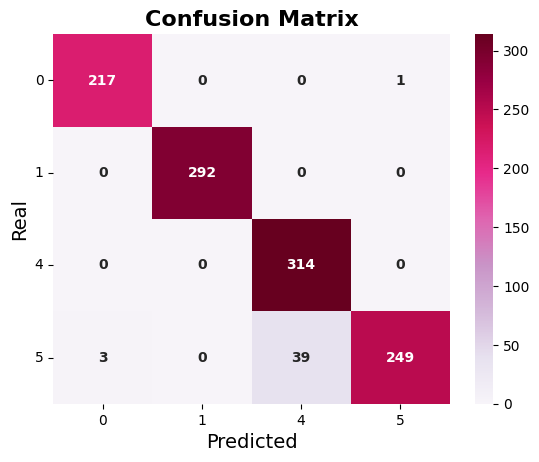

In [29]:
print(classification_report(y_test, log_reg_pred))

acc_logr_train = accuracy_score(train.label, log_reg_model.predict(X_train))
acc_logr_test = accuracy_score(y_test, log_reg_pred)

print(f'\nEin: {1 - acc_logr_train:.4f}')
print(f'Eout: {1 - acc_logr_test:.4f}\n')

plot_conf_matrix(confusion_matrix(y_test, log_reg_pred, [0, 1, 4, 5]))

In [30]:
print('Weights: ')
for idx, v in enumerate([1, 0, 4]):
    print(f'LOG_REG{v}: {log_reg_model.w[idx]}')

Weights: 
LOG_REG1: [261.61244934  -3.86470732   0.44517772]
LOG_REG0: [-1393.93737438    10.01289702     1.81949138]
LOG_REG4: [ 3.49734173e+03 -1.75094868e+00 -2.81827811e+01]


## Conclusion

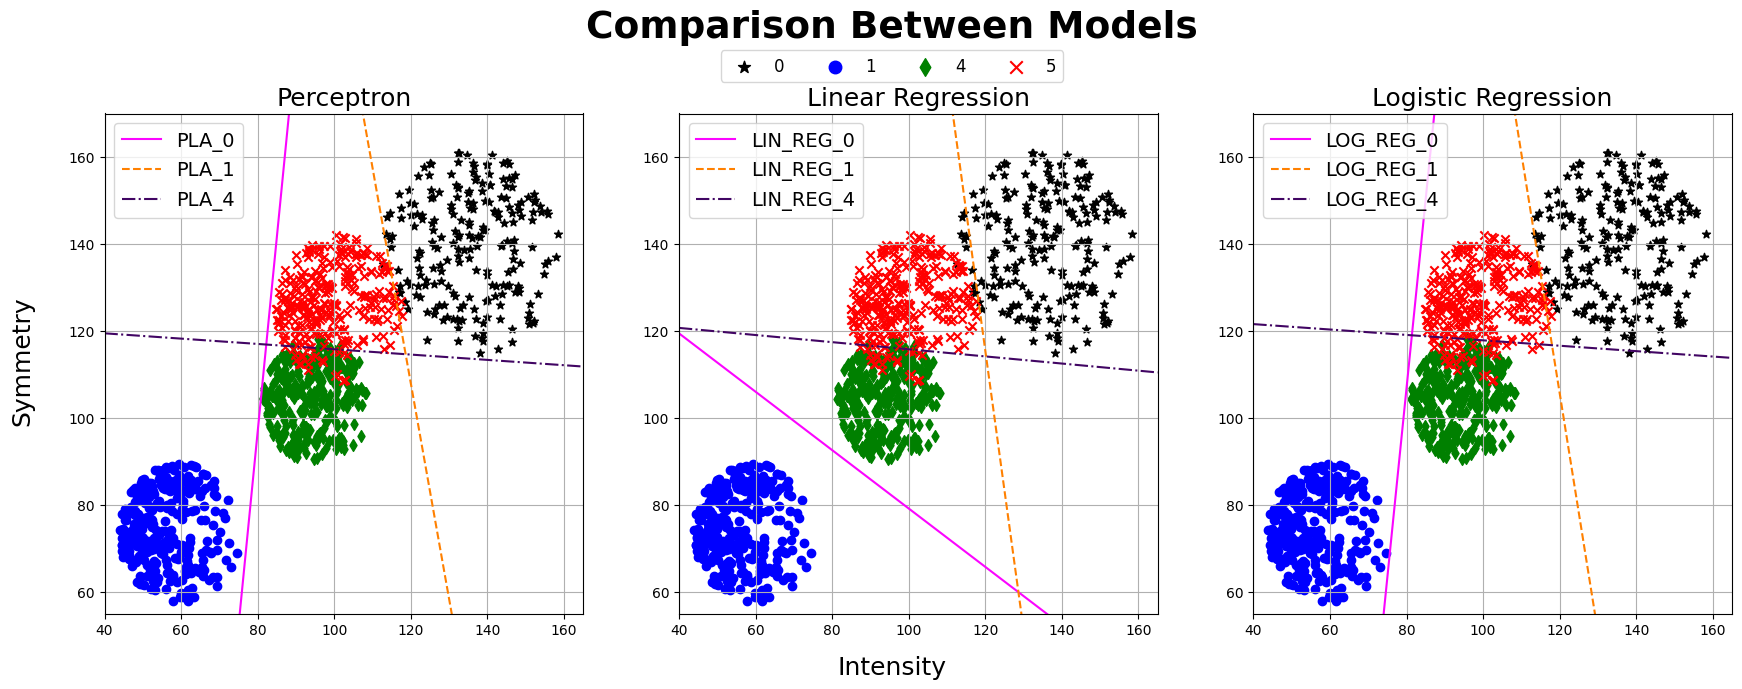

In [31]:
x = np.linspace(40, 165, 1000)
numbers = [0, 1, 4, 5]
colors = ['black', 'blue', 'green', 'red']
markers = ['*', 'o', 'd', 'x']
l_colors = ['#fb05ff', '#ff8000', '#410563']
lstyle = ['-', '--', '-.']
classifiers = ['PLA', 'LIN_REG', 'LOG_REG']
models = ['Perceptron', 'Linear Regression', 'Logistic Regression']
model_weights = [ppla_model.w, lin_reg_model.w, log_reg_model.w]
fig, ax = plt.subplots(1, 3, figsize=(21, 6.5))

for j in range(3):
    for i in range(4):
        ax[j].set_title(f"{models[j]}", fontsize=18)
        ax[j].scatter(test[test['label'] == numbers[i]]['intensity'],
                      test[test['label'] == numbers[i]]['symmetry'],
                      color=colors[i],
                      #label=numbers[i],
                      marker=markers[i])
for j in range(3):
    for i in range(3):
        if j == 2:
            a = model_weights[j][i][1] / -model_weights[j][i][2]
            b = model_weights[j][i][0] / -model_weights[j][i][2]
            ax[j].plot(x, a*x + b, 
                     c=l_colors[i], 
                     linestyle=lstyle[i], 
                     label=f"{classifiers[j]}_{numbers[i]}")
        else:
            ax[j].plot(x, (-model_weights[j][i][0] - model_weights[j][i][1]*x) / model_weights[j][i][2], 
                     c=l_colors[i], 
                     linestyle=lstyle[i], 
                     label=f"{classifiers[j]}_{numbers[i]}")
            
for i in range(3):
    ax[i].grid()
    ax[i].legend(loc='upper left', prop={'size': 14}, )
    ax[i].set_xlim([40, 165])
    ax[i].set_ylim([55, 170])
       
plt.suptitle("Comparison Between Models", fontsize=27, fontweight='bold', y= 1.04)
fig.supxlabel('Intensity', fontsize=18)
fig.supylabel('Symmetry', fontsize=18, x=0.08)
fig.legend([0, 1, 4, 5], 
           loc='upper center', 
           ncols=4, 
           bbox_to_anchor=(0.5, 0.99), 
           fontsize='large', 
           markerscale=1.5);

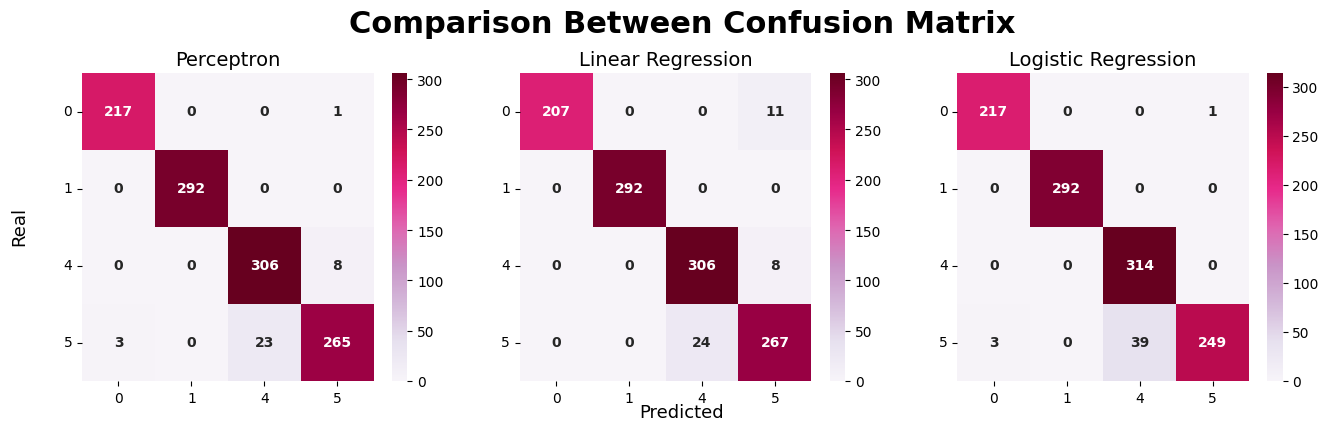

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

confs = [
    confusion_matrix(y_test, ppla_pred, [0, 1, 4, 5]),
    confusion_matrix(y_test, lin_reg_pred, [0, 1, 4, 5]),
    confusion_matrix(y_test, log_reg_pred, [0, 1, 4, 5])
]
for i in range(3):
    ax[i].set_title(f"{models[i]}", fontsize=14)
    sns.heatmap(confs[i], 
                annot=True, 
                fmt='.0f', 
                annot_kws={'fontsize': 10, 'fontweight': 'bold'},
                cmap='PuRd',
                ax=ax[i])
    ax[i].set_xticklabels([0, 1, 4, 5])
    ax[i].set_yticklabels([0, 1, 4, 5], rotation=0)

plt.suptitle("Comparison Between Confusion Matrix", fontsize=22, fontweight='bold', y= 1.04)
fig.supxlabel('Predicted', fontsize=13)
fig.supylabel('Real', fontsize=13, x=0.08);

In [33]:
print("Accuracies")
print('-'*11)
print(f"Perceptron: {acc_pla_test * 100:.2f}%")
print(f"Linear Regression: {acc_lin_test * 100:.2f}%")
print(f"Logistic Regression: {acc_logr_test * 100:.2f}%")

Accuracies
-----------
Perceptron: 96.86%
Linear Regression: 96.14%
Logistic Regression: 96.14%


In [34]:
print("Ein's and Eout's")
print('-'*17)
print("Perceptron: ")
print(f'    Ein: {(1 - acc_pla_train)*100:.2f}%')
print(f'    Eout: {(1 - acc_pla_test)*100:.2f}%')
print(f'    Ein - Eout: {((1 - acc_pla_train) - (1 - acc_pla_test))*100:.2f}')
print("Linear Regression: ")
print(f'    Ein: {(1 - acc_lin_train)*100:.2f}%')
print(f'    Eout: {(1 - acc_lin_test)*100:.2f}%')
print(f'    Ein - Eout: {((1 - acc_lin_train) - (1 - acc_lin_test))*100:.2f}')
print("Logistic Regression: ")
print(f'    Ein: {(1 - acc_logr_train)*100:.2f}%')
print(f'    Eout: {(1 - acc_logr_test)*100:.2f}%')
print(f'    Ein - Eout: {((1 - acc_logr_train) - (1 - acc_logr_test))*100:.2f}')

Ein's and Eout's
-----------------
Perceptron: 
    Ein: 4.85%
    Eout: 3.14%
    Ein - Eout: 1.71
Linear Regression: 
    Ein: 5.26%
    Eout: 3.86%
    Ein - Eout: 1.40
Logistic Regression: 
    Ein: 4.99%
    Eout: 3.86%
    Ein - Eout: 1.13
